# Test xgb code

In [111]:
%pylab inline
%load_ext autoreload
%autoreload 2
import os
import pandas as pd
from preprocess import loadPreData
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.cross_validation import KFold
subm_folder = './submissions'

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
data = loadPreData()

Index([u'Address', u'Species', u'Block', u'Street', u'Trap',
       u'AddressNumberAndStreet', u'Latitude', u'Longitude',
       u'AddressAccuracy', u'NumMosquitos', u'WnvPresent'],
      dtype='object')
Index([u'Id', u'Address', u'Species', u'Block', u'Street', u'Trap',
       u'AddressNumberAndStreet', u'Latitude', u'Longitude',
       u'AddressAccuracy'],
      dtype='object')


In [19]:
X = data['train'].get_values().astype(float)
Y = data['labels']

### Split data into train and validation set

In [33]:
# split data into train and test sets
seed = 7
test_size = 0.1
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

### Train model

In [34]:
# fit model 
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [35]:
preds = model.predict(X_test)

### Get accuracy on validation data

In [37]:
# evaluate predictions
accuracy = accuracy_score(y_test, preds)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 94.20%


## Plot AUC

In [94]:
def scoreAUC(y,probs):
    ps = np.linspace(0.,1.,num=100)
    prs = []
    nrs = []
    for p in ps:
        preds = probs[:,0]<p
        pr = np.sum((y & preds))/float(np.sum(y))
        nr = np.sum((1-y & 1-preds))/float(np.sum(1-y))
        nrs.append(nr)
        prs.append(pr)
    xs = 1-np.array(nrs)
    ys = np.array(prs)
    dxs = xs[1:] - xs[:-1]
    ays = .5*(ys[1:] + ys[:-1])
    auc = np.sum(ays*dxs)
    return {'score':auc,'fpr':xs,'tpr':ys}

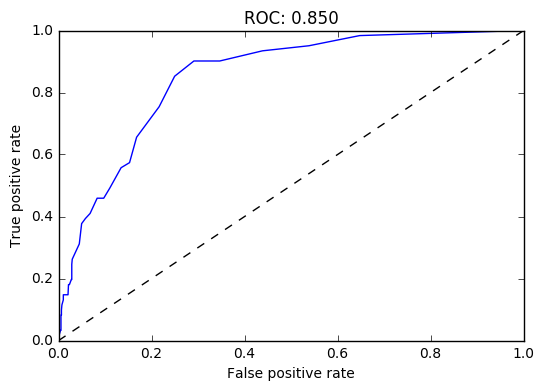

In [99]:
probs = model.predict_proba(X_test)
auc = scoreAUC(y_test,probs)
plt.plot(auc['fpr'],auc['tpr']);
plt.plot([0,1.],[0,1.],'k--');
plt.xlabel('False positive rate');
plt.ylabel('True positive rate');


plt.title('ROC: {:.3f}'.format(auc['score']));

In [102]:
X_sub = data['test'].get_values()

In [103]:
probs = model.predict_proba(X_sub)

In [108]:
#prepare submission
ss = pd.DataFrame(columns=['Id','WnvPresent'])
ss['WnvPresent'] = pd.Series(probs[:,1])
ss['Id'] = data['test'].index + 1
ss.to_csv(os.path.join(subm_folder, 'xgb_submission.csv'), index=False)

Produces score of 0.76064 so around 390th place

## xgb using Kfolds

In [109]:
X = data['train'].get_values().astype(float)
Y = data['labels']

In [112]:
nb_folds = 4
kfolds = KFold(len(Y), nb_folds)

In [133]:
av_roc = 0.
f = 0

fold_probs = []
aucs = []
for train, valid in kfolds:
    print('---'*20)
    print('Fold', f)
    print('---'*20)
    f += 1
    X_train = X[train]
    X_valid = X[valid]
    Y_train = Y[train]
    Y_valid = Y[valid]


    print("Building model...")
    model = XGBClassifier()

    print("Training model...")
    
    model.fit(X_train, Y_train)
    probs = model.predict_proba(X_valid)
    auc = scoreAUC(Y_valid,probs)
    print 'AUC : {}'.format(auc['score'])
    
    fold_prob = model.predict_proba(X_sub)
    fold_probs.append(fold_prob)
    aucs.append(auc['score'])

------------------------------------------------------------
('Fold', 0)
------------------------------------------------------------
Building model...
Training model...
AUC : 0.76204927286
------------------------------------------------------------
('Fold', 1)
------------------------------------------------------------
Building model...
Training model...
AUC : 0.771135467022
------------------------------------------------------------
('Fold', 2)
------------------------------------------------------------
Building model...
Training model...
AUC : 0.785425368628
------------------------------------------------------------
('Fold', 3)
------------------------------------------------------------
Building model...
Training model...
AUC : 0.758053494398


In [141]:
aucs = np.array(aucs)
aucs = aucs/np.sum(aucs)
fold_probs = np.array(fold_probs)

In [142]:
fprobs = fold_probs[:,:,1]

In [144]:
subs = np.sum((np.tile(aucs,(fprobs.shape[1],1)).T)*fprobs,axis=0)

In [145]:
subs.shape

(116293,)

In [146]:
#prepare submission
ss = pd.DataFrame(columns=['Id','WnvPresent'])
ss['WnvPresent'] = pd.Series(subs)
ss['Id'] = data['test'].index + 1
ss.to_csv(os.path.join(subm_folder, 'xgb_kfold_submission.csv'), index=False)

Score of 0.75533 so slightly worse